In [1]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
import re
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

from pandas.tseries.offsets import DateOffset
from glob import glob


from datetime import datetime as dt
from sklearn.model_selection import train_test_split, TimeSeriesSplit

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, make_scorer, precision_recall_fscore_support, roc_curve, roc_auc_score, auc, accuracy_score
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.pipeline import Pipeline
from pprint import pprint
from time import time

pd.options.mode.chained_assignment = None  # default='warn'

red  = '#b41f4c'
blue = '#1f77b4'
gold = '#b49e1f'

## Load Data - New

In [2]:
pd.set_option('display.max_colwidth',280)
pd.set_option('display.html.use_mathjax', False)
pd.set_option('display.max_rows', 1000)

In [3]:
src_path = r'c:\Users\jaromir\OneDrive\UoM\100_Disertation\02_SrcData\04_CleanData'

In [4]:
filenames = glob(src_path+'\*.pkl')

In [5]:
for file in filenames:
    if file.find('stock') > 0 :
        stock_prices = pd.read_pickle(file)

In [6]:
stock_prices.shape

(1500, 10)

In [7]:
stock_prices.groupby(['ticker']).ticker.count()

ticker
AAPL    125
AMZN    125
BABA    125
DAL     125
GILD    125
HLT     125
JNJ     125
MAR     125
MCD     125
MSFT    125
QSR     125
UAL     125
Name: ticker, dtype: int64

In [8]:
stock_prices.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker,Adj close,Category
Date,,,,,,,,,,
2019-12-31,287.94,291.67,287.54,291.64,25201400,0.0,0,AAPL,291.64,technology
2020-01-02,294.21,298.54,293.17,298.29,33870100,0.0,0,AAPL,298.29,technology
2020-01-03,295.11,298.52,294.47,295.39,36580700,0.0,0,AAPL,295.39,technology
2020-01-06,291.78,297.90,290.74,297.75,29596800,0.0,0,AAPL,297.75,technology
2020-01-07,297.79,298.84,295.44,296.35,27218000,0.0,0,AAPL,296.35,technology


## Label Data

In [9]:
def label_fin_data(input_df, attribute):
    """ For an entry DataFrame and a numeric attribute, it assigns labels according to whether the 
    next day's price goes up (1) or down (0). The last value is NaN"""
    
    df = pd.DataFrame()
    for ticker in input_df.ticker.unique():
        # choose one company 
        company_df = input_df.loc[input_df.ticker == ticker]

        # for each entry point t calcualte whether price at t is higher or lower than at t-1
        t_series = company_df[attribute].diff(1) > 0

        # offset the calcualted labels by one day i.e. if price went up on day t+1, then t  = True
        t_series = pd.Series(data = t_series.values[1:], index = t_series.index[:-1], name='class')

        # merge the labels with the rest of the DataFrame
        company_df = pd.concat([company_df,t_series], axis=1)

        # relabel the clases to be 1 for the price goes up and 0 for the price goes down
        company_df['class'] = company_df.loc[:,'class'].apply(lambda x: 1 if x == True else (0 if x == False else np.nan))

        # insert the company sepcific df into a new DataFrame
        df = df.append(company_df)
    
    # remove all rows with NaN - one for each company because the last day doesn't have a class
    df.dropna(axis=0, how='any', inplace=True)
        
    return df

In [10]:
stock_prices = label_fin_data(stock_prices, 'Adj close')
stock_prices.drop(['Open','High','Low','Close','Volume','Dividends','Stock Splits'], axis=1, inplace=True)
stock_prices.head()

,ticker,Adj close,Category,class
Date,,,,
2019-12-31,AAPL,291.64,technology,1.0
2020-01-02,AAPL,298.29,technology,0.0
2020-01-03,AAPL,295.39,technology,1.0
2020-01-06,AAPL,297.75,technology,0.0
2020-01-07,AAPL,296.35,technology,1.0


In [11]:
stock_prices_stationery = stock_prices.loc[:,['Adj close']].diff(1)
stock_prices_stationery = pd.concat([stock_prices.loc[:,~stock_prices.columns.isin(['Adj close'])], stock_prices_stationery], axis=1).dropna()

In [12]:
stock_prices_stationery.head()

,ticker,Category,class,Adj close
Date,,,,
2020-01-02,AAPL,technology,0.0,6.65
2020-01-03,AAPL,technology,1.0,-2.90
2020-01-06,AAPL,technology,0.0,2.36
2020-01-07,AAPL,technology,1.0,-1.40
2020-01-08,AAPL,technology,1.0,4.76


## Feature Engineering

In [13]:
from statsmodels.graphics.tsaplots import plot_acf

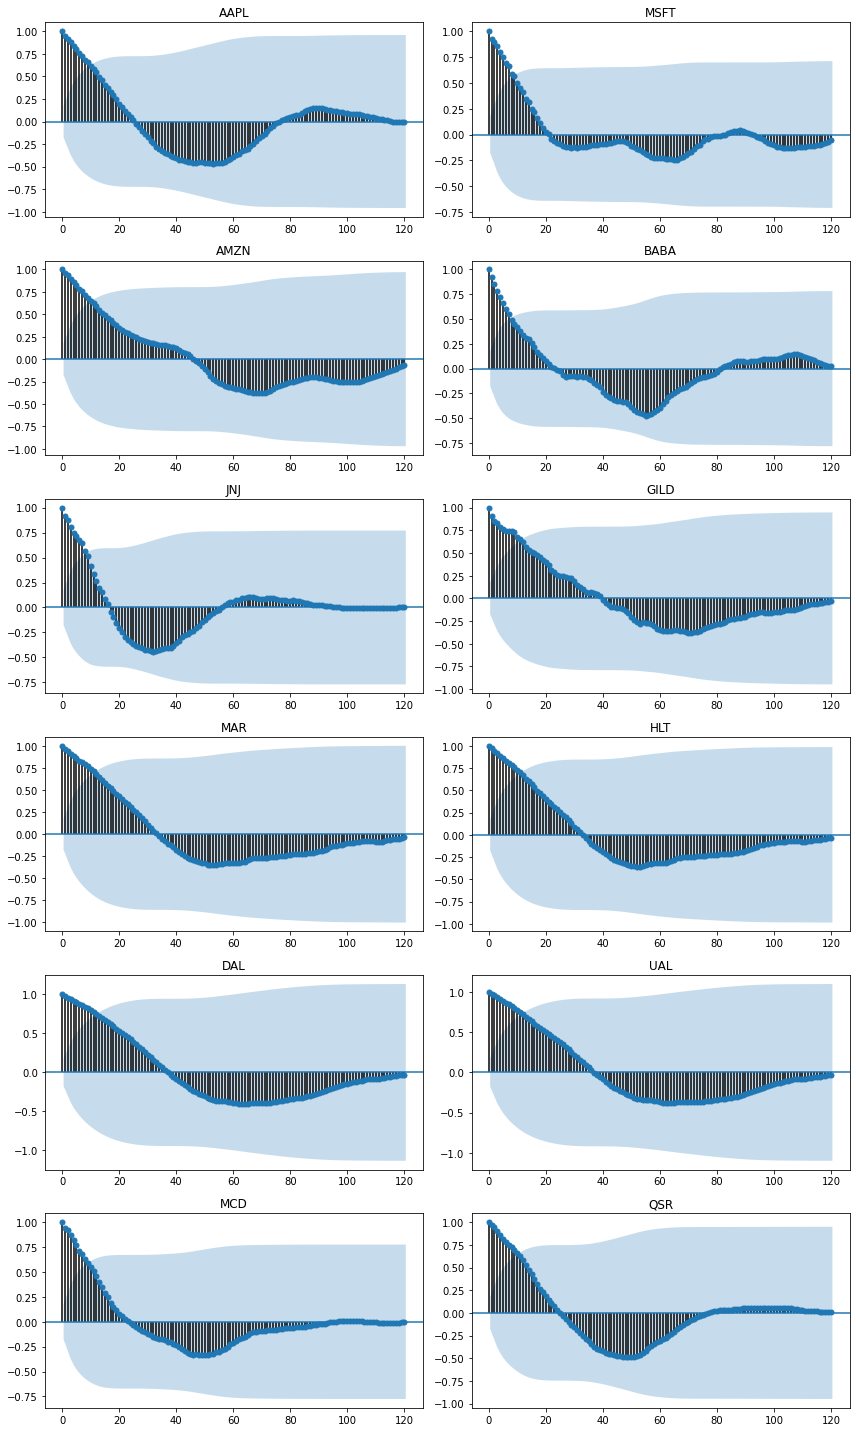

In [14]:
n_rows = int(len(stock_prices.ticker.unique())/2)
n_cols = 2
data = {}
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 20))
axes = axes.flatten()

for idx, tick in enumerate(stock_prices.ticker.unique()):
    plot_acf(stock_prices.loc[stock_prices.ticker == tick,'Adj close'], lags=120, ax = axes[idx], title=tick)
    
    line = axes[idx].lines[1] # get the first line, there might be more
    xy = line.get_xydata()
    data[tick] = xy

    plt.tight_layout()
plt.show()

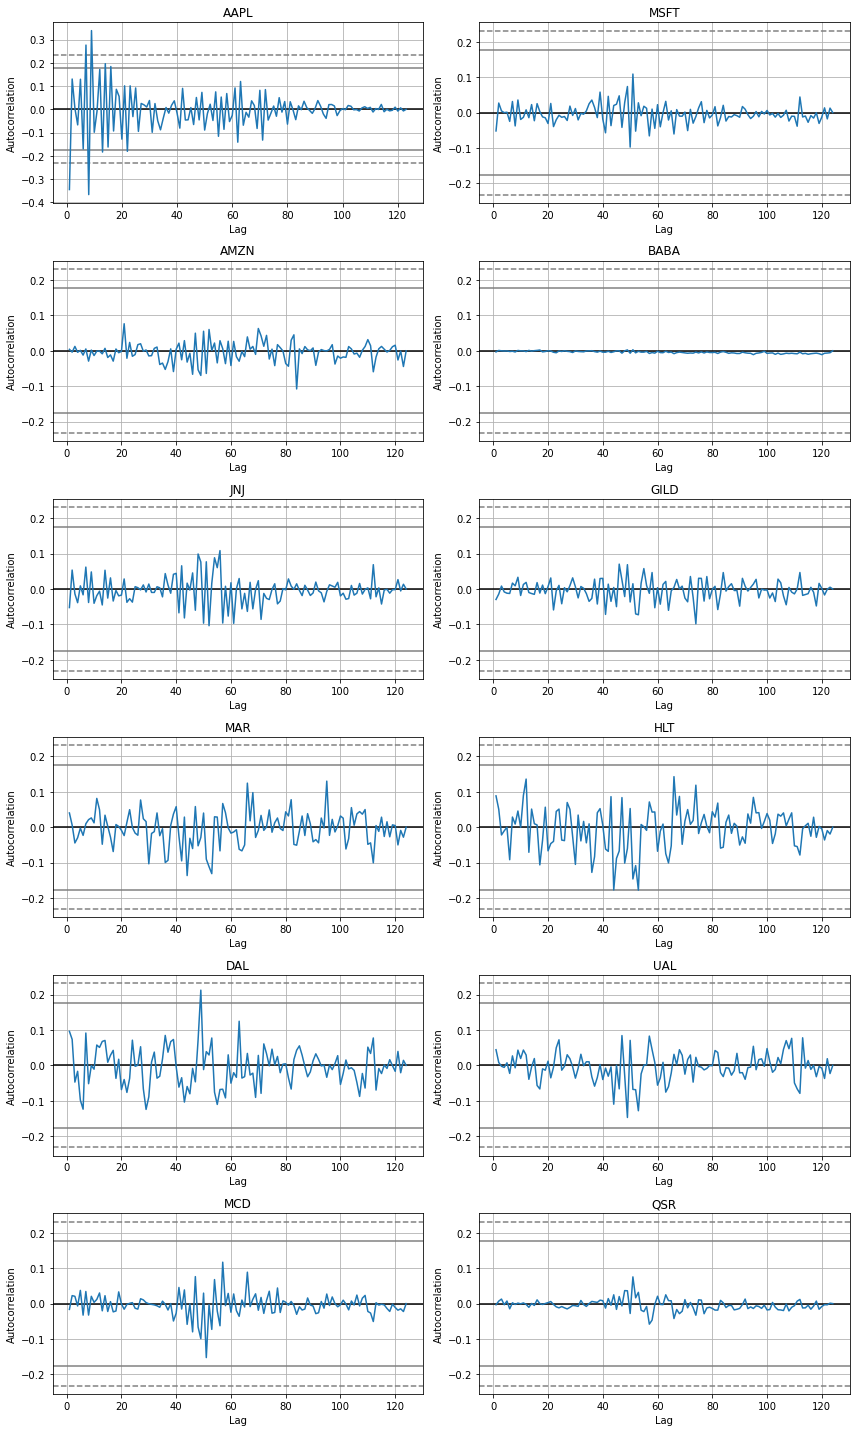

In [15]:
n_rows = int(len(stock_prices.ticker.unique())/2)
n_cols = 2
data = {}
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 20))
axes = axes.flatten()

for idx, tick in enumerate(stock_prices.ticker.unique()):
    autocorrelation_plot(stock_prices_stationery.loc[stock_prices_stationery.ticker == tick,'Adj close'], ax = axes[idx])
    axes[idx].set(title=tick)
    
    line = axes[idx].lines[1] # get the first line, there might be more
    xy = line.get_xydata()
    data[tick] = xy

    plt.tight_layout()
plt.show()

## Original

In [16]:
# Rolling statistics
for ticker in stock_prices.ticker.unique():
    window3 = stock_prices.loc[stock_prices.ticker == ticker,'Adj close'].rolling(3) #'3D'
    window5 = stock_prices.loc[stock_prices.ticker == ticker,'Adj close'].rolling(5) #'5D'
    window7 = stock_prices.loc[stock_prices.ticker == ticker,'Adj close'].rolling(7) #'7D'
    
    # mean
    name = 'mean'
    stock_prices.loc[stock_prices.ticker == ticker,'MA_3D_'+name] = window3.mean()
    stock_prices.loc[stock_prices.ticker == ticker,'MA_5D_'+name] = window5.mean()
    stock_prices.loc[stock_prices.ticker == ticker,'MA_7D_'+name] = window7.mean()
    
    # std
    name = 'std'
    stock_prices.loc[stock_prices.ticker == ticker,'MA_3D_'+name] = window3.std()
    stock_prices.loc[stock_prices.ticker == ticker,'MA_5D_'+name] = window5.std()
    stock_prices.loc[stock_prices.ticker == ticker,'MA_7D_'+name] = window7.std()
    
    # min
    name = 'min'
    stock_prices.loc[stock_prices.ticker == ticker,'MA_3D_'+name] = window3.min()
    stock_prices.loc[stock_prices.ticker == ticker,'MA_5D_'+name] = window5.min()
    stock_prices.loc[stock_prices.ticker == ticker,'MA_7D_'+name] = window7.min()
    
    # max
    name = 'max'
    stock_prices.loc[stock_prices.ticker == ticker,'MA_3D_'+name] = window3.max()
    stock_prices.loc[stock_prices.ticker == ticker,'MA_5D_'+name] = window5.max()
    stock_prices.loc[stock_prices.ticker == ticker,'MA_7D_'+name] = window7.max()

In [17]:
# Time lag t-1, t-2, t-n
shifts = [1,2,3,4,5,6,7,8,9,10,15]

for tick in stock_prices.ticker.unique():
    for shift in shifts:
        cond = stock_prices.ticker == tick
        stock_prices.loc[cond,f"lag_{shift}"] = stock_prices.loc[cond,'Adj close'].shift(shift)

In [18]:
stock_prices

,ticker,Adj close,Category,class,MA_3D_mean,MA_5D_mean,MA_7D_mean,MA_3D_std,MA_5D_std,MA_7D_std,...,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_15
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-31,AAPL,291.64,technology,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,AAPL,298.29,technology,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,AAPL,295.39,technology,1.0,295.106667,NaN,NaN,3.334042,NaN,NaN,...,291.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-06,AAPL,297.75,technology,0.0,297.143333,NaN,NaN,1.542249,NaN,NaN,...,298.29,291.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-07,AAPL,296.35,technology,1.0,296.496667,295.884,NaN,1.186816,2.633606,NaN,...,295.39,298.29,291.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-22,QSR,55.10,restaurants,0.0,55.093333,55.354,55.387143,0.920018,0.808783,0.675961,...,56.01,56.20,55.29,55.70,55.24,54.71,57.09,58.91,59.18,55.30
2020-06-23,QSR,55.07,restaurants,0.0,54.780000,55.310,55.362857,0.528488,0.819054,0.685121,...,54.17,56.01,56.20,55.29,55.70,55.24,54.71,57.09,58.91,56.56
2020-06-24,QSR,54.42,restaurants,0.0,54.863333,54.954,55.180000,0.384231,0.715842,0.748064,...,55.10,54.17,56.01,56.20,55.29,55.70,55.24,54.71,57.09,58.01


# Stationery

In [19]:
# Rolling statistics
for ticker in stock_prices_stationery.ticker.unique():
    window3 = stock_prices_stationery.loc[stock_prices_stationery.ticker == ticker,'Adj close'].rolling(3) #'3D'
    window5 = stock_prices_stationery.loc[stock_prices_stationery.ticker == ticker,'Adj close'].rolling(5) #'5D'
    window7 = stock_prices_stationery.loc[stock_prices_stationery.ticker == ticker,'Adj close'].rolling(7) #'7D'
    
    # mean
    name = 'mean'
    stock_prices_stationery.loc[stock_prices_stationery.ticker == ticker,'MA_3D_'+name] = window3.mean()
    stock_prices_stationery.loc[stock_prices_stationery.ticker == ticker,'MA_5D_'+name] = window5.mean()
    stock_prices_stationery.loc[stock_prices_stationery.ticker == ticker,'MA_7D_'+name] = window7.mean()
    
    # std
    name = 'std'
    stock_prices_stationery.loc[stock_prices_stationery.ticker == ticker,'MA_3D_'+name] = window3.std()
    stock_prices_stationery.loc[stock_prices_stationery.ticker == ticker,'MA_5D_'+name] = window5.std()
    stock_prices_stationery.loc[stock_prices_stationery.ticker == ticker,'MA_7D_'+name] = window7.std()
    
    # min
    name = 'min'
    stock_prices_stationery.loc[stock_prices_stationery.ticker == ticker,'MA_3D_'+name] = window3.min()
    stock_prices_stationery.loc[stock_prices_stationery.ticker == ticker,'MA_5D_'+name] = window5.min()
    stock_prices_stationery.loc[stock_prices_stationery.ticker == ticker,'MA_7D_'+name] = window7.min()
    
    # max
    name = 'max'
    stock_prices_stationery.loc[stock_prices_stationery.ticker == ticker,'MA_3D_'+name] = window3.max()
    stock_prices_stationery.loc[stock_prices_stationery.ticker == ticker,'MA_5D_'+name] = window5.max()
    stock_prices_stationery.loc[stock_prices_stationery.ticker == ticker,'MA_7D_'+name] = window7.max()

In [20]:
# Time lag t-1, t-2, t-n
shifts = [1,2,3,4,5,6,7,8,9,10,15]

for tick in stock_prices_stationery.ticker.unique():
    for shift in shifts:
        cond = stock_prices_stationery.ticker == tick
        stock_prices_stationery.loc[cond,f"lag_{shift}"] = stock_prices_stationery.loc[cond,'Adj close'].shift(shift)

In [21]:
stock_prices_stationery

,ticker,Category,class,Adj close,MA_3D_mean,MA_5D_mean,MA_7D_mean,MA_3D_std,MA_5D_std,MA_7D_std,...,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_15
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,AAPL,technology,0.0,6.65,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,AAPL,technology,1.0,-2.90,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-06,AAPL,technology,0.0,2.36,2.036667,NaN,NaN,4.783203,NaN,NaN,...,6.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-07,AAPL,technology,1.0,-1.40,-0.646667,NaN,NaN,2.709711,NaN,NaN,...,-2.90,6.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-08,AAPL,technology,1.0,4.76,1.906667,1.894,NaN,3.104921,4.027515,NaN,...,2.36,-2.90,6.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-22,QSR,restaurants,0.0,0.93,-0.366667,-0.120,0.055714,1.393425,1.141359,0.979249,...,-0.19,0.91,-0.41,0.46,0.53,-2.38,-1.82,-0.27,0.33,1.24
2020-06-23,QSR,restaurants,0.0,-0.03,-0.313333,-0.044,-0.024286,1.406568,1.129814,0.956658,...,-1.84,-0.19,0.91,-0.41,0.46,0.53,-2.38,-1.82,-0.27,1.26
2020-06-24,QSR,restaurants,0.0,-0.65,0.083333,-0.356,-0.182857,0.796074,1.009495,0.954999,...,0.93,-1.84,-0.19,0.91,-0.41,0.46,0.53,-2.38,-1.82,1.45


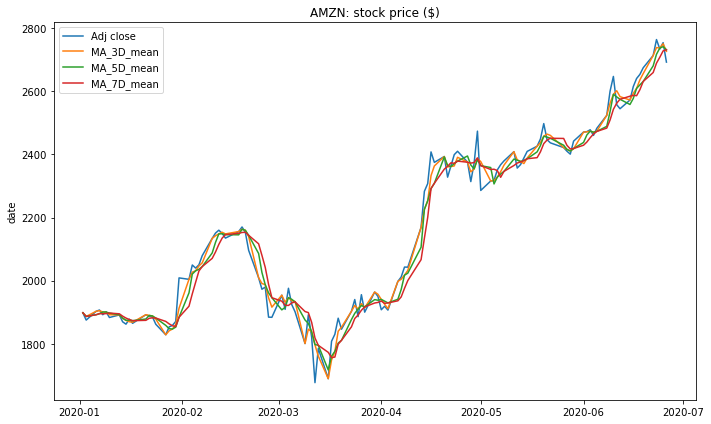

In [30]:
tick = 'AMZN'
features = ['Adj close','MA_3D_mean','MA_5D_mean','MA_7D_mean']

fig, ax = plt.subplots(figsize=(10,6))

for f in features:
    ax.plot(stock_prices.loc[stock_prices.ticker == tick,f], label=f)

plt.title(tick+': stock price ($)')
plt.ylabel('stock price')
plt.ylabel('date')
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
# save file
current_time = str(datetime.now().strftime("%Y%m%d_%H%M%S"))
stock_prices.to_pickle(r'c:\Users\jaromir\OneDrive\UoM\100_Disertation\02_SrcData\05_PreProcessed\\processed_fin_'+current_time+".pkl")
stock_prices_stationery.to_pickle(r'c:\Users\jaromir\OneDrive\UoM\100_Disertation\02_SrcData\05_PreProcessed\\processed_fin_stat_'+current_time+".pkl")

## EDA

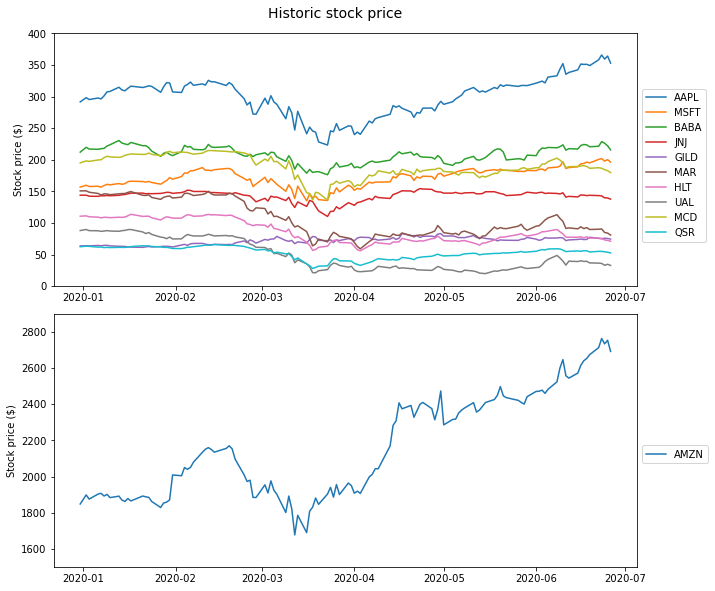

In [14]:
fig_name = 'Historic stock price'
fig, ax = plt.subplots(2,1,figsize=(10,8))

for ticker in stock_prices.ticker.unique():
    if ticker != 'AMZN':        
        ax[0].plot(stock_prices[stock_prices.ticker == ticker]['Adj close'], label =ticker)
        ax[0].set_ylim([0,400])
        ax[0].set_ylabel('Stock price ($)')
        ax[0].legend(bbox_to_anchor=(1, 0.8))
    else:
        ax[1].plot(stock_prices[stock_prices.ticker == ticker]['Adj close'], label =ticker)
        ax[1].set_ylim([1500,2900])
        ax[1].set_ylabel('Stock price ($)')
        ax[1].legend(bbox_to_anchor=(1.13, 0.5))
    
fig.suptitle(fig_name, fontsize = 14, x = 0.47,y = 1.02)
plt.tight_layout()
fig.savefig(r'c:\Users\jaromir\OneDrive\UoM\100_Disertation\05_Dissertation\01_Figures\\'+fig_name+'.png')
plt.show()

In [15]:
# how balanced are our data ?
class_proportions = pd.DataFrame(columns=['ticker','training_size','type','value'])

idx = 0
for tick in stock_prices.ticker.unique():
    
    X_features = ['Adj close']
    X = stock_prices.loc[stock_prices.ticker == tick, X_features]
    y = stock_prices.loc[stock_prices.ticker == tick,'class']

    train_size = range(1, X.shape[0] - 1,1)

    train_results = []
    test_results = []
    
    for tr in train_size:
        X_train, X_test, y_train, y_test = train_test_split( X, y, train_size=tr, random_state=42, shuffle=False)
        
        train = y_train.sum()/y_train.shape[0] 
        test = y_test.sum()/y_test.shape[0] 
        
        class_proportions.loc[idx] = [tick, tr, 'train', train]
        idx += 1
        class_proportions.loc[idx] = [tick, tr, 'test', test]
        idx += 1

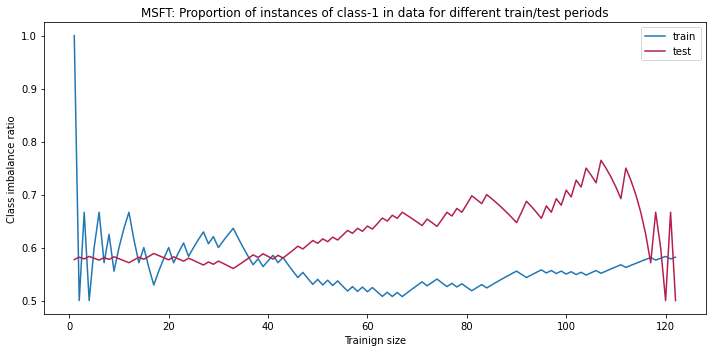

In [603]:
fig, axes = plt.subplots(1,1, figsize=(10,5))

for tick in ['MSFT'] : #class_proportions.ticker.unique():
    
    x = class_proportions[(class_proportions.ticker==tick) & (class_proportions.type=='train')].training_size.values
    y = class_proportions[(class_proportions.ticker==tick) & (class_proportions.type=='train')].value.values
    
    axes.plot( x,  y, c=blue, label='train')
    
    x = class_proportions[(class_proportions.ticker==tick) & (class_proportions.type=='test')].training_size.values
    y = class_proportions[(class_proportions.ticker==tick) & (class_proportions.type=='test')].value.values
       
    axes.plot( x, y, c=red, label='test')
        

plt.xlabel('Trainign size')
plt.ylabel('Class imbalance ratio')
plt.title(tick + ": Proportion of instances of class-1 in data for different train/test periods")
plt.legend()
plt.tight_layout()
plt.show()

In [635]:
# how balanced are our data CV 
class_proportions = pd.DataFrame(columns=['ticker','test_size','type','value'])

idx = 0
for tick in stock_prices.ticker.unique():
    
    X_features = ['Adj close']
    X = stock_prices.loc[stock_prices.ticker == tick, X_features]
    y = stock_prices.loc[stock_prices.ticker == tick,'class']

    splits = np.arange(2,11,1)
    
   
    for i, n_splits in enumerate(splits):
        cv = TimeSeriesSplit(n_splits=n_splits)
        
        test_size = X.shape[0]//(n_splits + 1)
        
        train_results = []
        test_results = []
        
        for tr, tt in cv.split(X, y):
        
            train = y[tr].sum()/y[tr].shape[0] 
            test = y[tt].sum()/y[tt].shape[0] 

            class_proportions.loc[idx] = [tick, test_size, 'train', train]
            idx += 1
            class_proportions.loc[idx] = [tick, test_size, 'test', test]
            idx += 1

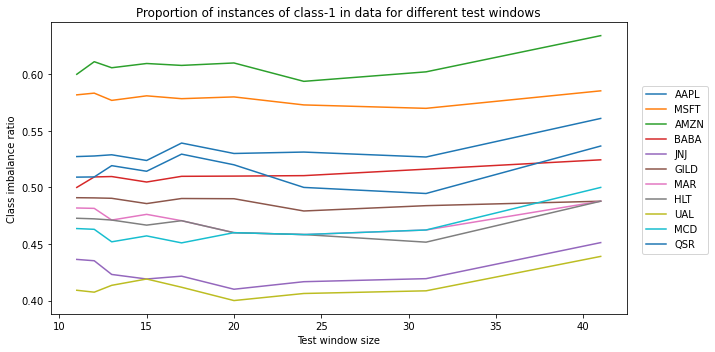

In [649]:
fig, axes = plt.subplots(1,1, figsize=(10,5))

for tick in stock_prices.ticker.unique():
    
    df = class_proportions[(class_proportions.ticker == tick) &
                      (class_proportions.type == 'test')].groupby(['ticker','test_size','type']).value.mean().reset_index()
    
    
    axes.plot(df.test_size , df.value, label = tick )
    
plt.xlabel('Test window size')
plt.ylabel('Class imbalance ratio')
plt.title('Proportion of instances of class-1 in data for different test windows')
plt.legend(bbox_to_anchor=(1.15, 0.8))
plt.tight_layout()
plt.show()

## Stationarity check - Augmented Dickey Fuller

Since the VAR model requires the time series you want to forecast to be stationary, it is customary to check all the time series in the system for stationarity.

A stationary time series is one whose characteristics like mean and variance does not change over time.

We cant test for stationarity using a a suite of tests called unit-root tests. The popular ones are:

* Augmented Dickey-Fuller Test (ADF Test)
* KPSS test
* Philip-Perron test  

if a series is found to be non-stationary, you make it stationary by differencing the series once and repeat the test again until it becomes stationary.

The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root. If the pvalue is above a critical size, then we cannot reject that there is a unit root.

The p-values are obtained through regression surface approximation from MacKinnon 1994, but using the updated 2010 tables. If the p-value is close to significant, then the critical values should be used to judge whether to reject the null.

The autolag option and maxlag for it are described in Greene.

In [17]:
from statsmodels.tsa.stattools import adfuller, grangercausalitytests

In [18]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

#     # Print Summary
#     print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
#     print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
#     print(f' Significance Level    = {signif}')
#     print(f' Test Statistic        = {output["test_statistic"]}')
#     print(f' No. Lags Chosen       = {output["n_lags"]}')

#     for key,val in r[4].items():
#         print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        stationery = 1
        #print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        #print(f" => Series is Stationary.")
    else:
        #print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        #print(f" => Series is Non-Stationary.") 
        stationery = 0
          
    return stationery, p_value

In [19]:
# ADF Test on each column - not transformed
stationery_df = pd.DataFrame()

stats = []
p = []

for tick in stock_prices.ticker.unique():
    test_series = stock_prices.loc[stock_prices.ticker==tick,'Adj close']
    stationery, p_value = adfuller_test(test_series, name=test_series.name)
    stats.append(stationery)
    p.append(p_value)
    
stationery_df['p_value'] = p
stationery_df['stationery'] = stats
stationery_df.index = stock_prices.ticker.unique()

stationery_df

,p_value,stationery
AAPL,0.8243,0
MSFT,0.5181,0
AMZN,0.9522,0
BABA,0.2172,0
JNJ,0.0953,0
GILD,0.4642,0
MAR,0.5835,0
HLT,0.5904,0
UAL,0.5321,0
MCD,0.3839,0


In [25]:
# ADF Test on each column with diff

stationery_df = pd.DataFrame()

stats = []
p = []

for tick in stock_prices.ticker.unique():
    test_series = stock_prices.loc[stock_prices.ticker==tick,'Adj close'].diff().dropna()
    stationery, p_value = adfuller_test(test_series, name=test_series.name)
    stats.append(stationery)
    p.append(p_value)
    
stationery_df['p_value'] = p
stationery_df['stationery'] = stats
stationery_df.index = stock_prices.ticker.unique()

stationery_df

,p_value,stationery
AAPL,0.0250,1
MSFT,0.0595,0
AMZN,0.0000,1
BABA,0.0000,1
JNJ,0.1113,0
GILD,0.0029,1
MAR,0.0000,1
HLT,0.0000,1
UAL,0.0000,1
MCD,0.0020,1


non of the time-series is stationery

## Choosing the right train-test split

Here we are interested in which train-test split mehtod yiedls the most consistent (informative) results across the chosen period. 

We try:
- holdout method,
- time-series cross validation and,
- moving window

we also experiement with data transformation, to explore whether it improves the results. In paritcualr we try:
- differencing
- standardization

### holdout

In [26]:
company = 'MSFT'
X_features = ['Adj close']
X = stock_prices.loc[stock_prices.ticker == company, X_features]
y = stock_prices.loc[stock_prices.ticker == company,'class']

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=20, random_state=42, shuffle=False)

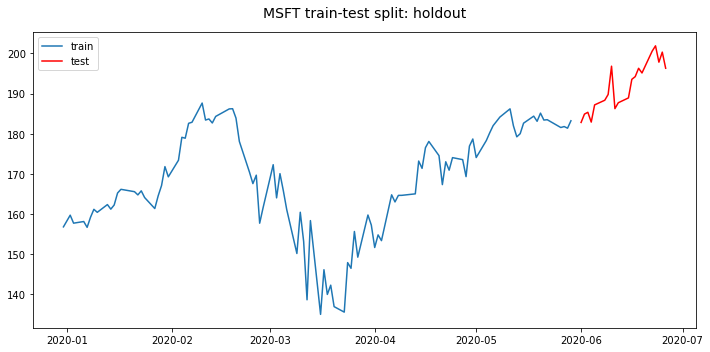

In [27]:
fig, axes = plt.subplots(1,1, figsize=(10,5))
axes.plot(X_train, label='train')
axes.plot(X_test, c='r', label='test')
plt.title(company+' train-test split: holdout', fontsize=14, pad = 15)
plt.legend()
plt.tight_layout()
plt.show()

We see that it is not guaranteed that either train or test sets have balanaced class representation. This means, that we should chose a performance metric that can account for this imbalance. Such as fscore or auc. 

In [28]:
def run_ho_model(model, X_train, X_test, y_train, y_test):
    try:
        # Teach model onto train data
        model.fit(X_train,y_train)

        # Get prediction on test set
        y_pred = model.predict(X_test)

        # Get decision function for ROC
        ydf = model.decision_function(X_test)

        # Calculate performance metrics  
        accuracy = accuracy_score(y_test, y_pred)
        precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred,
                                                                             average='weighted',
                                                                             zero_division = 0)
        # Get ROC AUC
        ydf = model.decision_function(X_test)
        auc_score = roc_auc_score(y_test, ydf)               

        return (accuracy, precision, recall, fscore, auc_score)
        
    except:
        return np.nan

### Holdout model with raw price data 

In [424]:
company = 'MSFT'
X_features = ['Adj close']
X = stock_prices.loc[stock_prices.ticker == company, X_features]
y = stock_prices.loc[stock_prices.ticker == company,'class']
first_indices = []

train_size = range(1, X.shape[0] - 1,1)
df_holdout = pd.DataFrame(columns=['accuracy','precision','recall','fscore','auc'])

for ts in train_size:
    X_train, X_test, y_train, y_test = train_test_split( X, y, train_size=ts, random_state=42, shuffle=False)
    
    
    first_indices.append(X_test.index.values[0])
    
    
    svc = SVC(random_state=42)
    
    # for test sample with only one class, metrics cannot be computed and the function returns NaN
    # to avoid errors we simply disregard such results
    try:
        accuracy, precision, recall, fscore, auc_score = run_ho_model(svc, X_train, X_test, y_train, y_test )
        df_holdout.loc[ts] = [accuracy, precision, recall, fscore, auc_score]
    
    except:
        pass
    

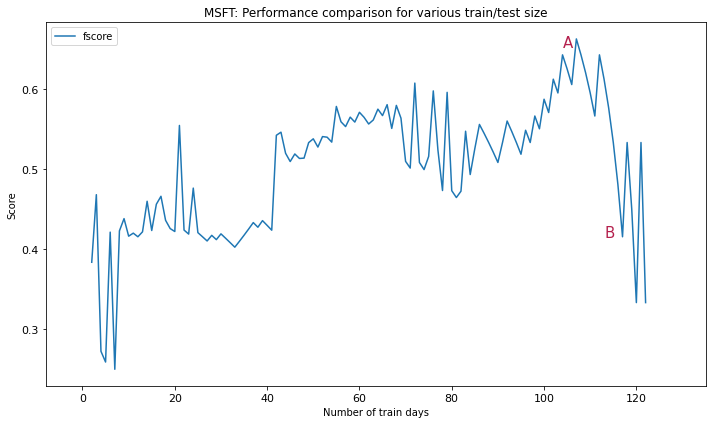

In [472]:
attr = 'fscore'

fig, axes = plt.subplots(1,1, figsize=(10,6))

df_holdout.sort_index().loc[:,[attr]].plot( color = ['#1f77b4','#b49e1f'],
                                      title='MSFT: Performance comparison for various train/test size',
                                      fontsize = 11,
                                      ax = axes)

#ax.hlines(y = 0.5, xmin=0-5, xmax=df_holdout.shape[0]+5, alpha = 0.7, color='#b41f4c', linestyle='dashed', label = 'random guessing')
max_val = df_holdout.loc[100:,'fscore'].max()
x_max = int(df_holdout.loc[df_holdout.fscore == max_val,attr].index.values)

min_val = df_holdout.loc[100:118,'fscore'].min()
x_min = int(df_holdout.loc[df_holdout.fscore == min_val,attr].index.values[0])

axes.annotate("A",
            xy=(x_max - 3, max_val - 0.01 ),
            color='#b41f4c',
            fontsize=15)
axes.annotate(f"B", # {x_min, np.round(min_val,2)}
            xy=(x_min + 101 , min_val),
            color='#b41f4c',
            fontsize=15)
axes.set(xlabel = 'Number of train days', ylabel = 'Score' , xlim=(-8,135))
axes.legend(loc='upper left')




plt.tight_layout()

plt.show()

In [576]:
df_holdout.sort_index().loc[:,['fscore']]

,fscore
2,0.383722
3,0.468158
4,0.272495
5,0.259095
6,0.421360
7,0.250037
8,0.422932
9,0.438240
10,0.416322
11,0.420105


In [574]:
fscore = df_holdout.sort_index().loc[:,['fscore']].values
adj_close = X.iloc[2:-1,:]
adj_close['fscore'] = fscore

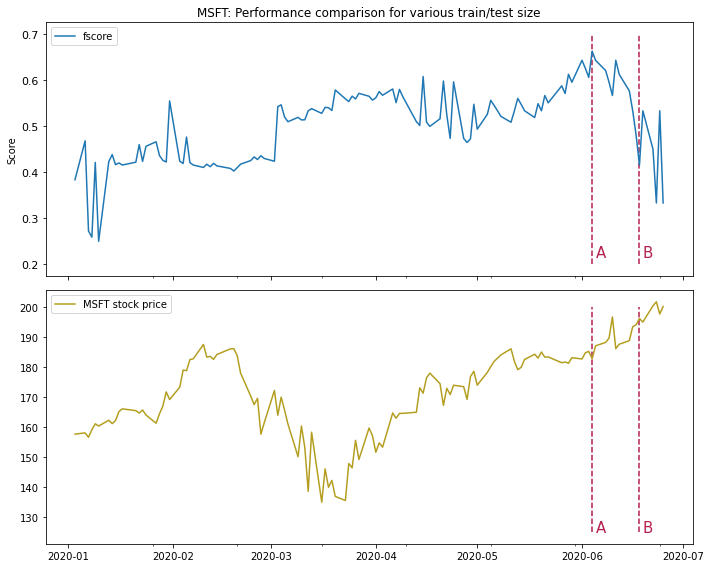

In [578]:
attr = 'fscore'

fig, axes = plt.subplots(2,1, figsize=(10,8), sharex=True)

adj_close.sort_index().loc[:,[attr]].plot( color = ['#1f77b4','#b49e1f'],
                                      title='MSFT: Performance comparison for various train/test size',
                                      fontsize = 11,
                                      ax = axes[0])

#ax.hlines(y = 0.5, xmin=0-5, xmax=df_holdout.shape[0]+5, alpha = 0.7, color='#b41f4c', linestyle='dashed', label = 'random guessing')
max_val = adj_close.iloc[100:,1].max()
x_max = adj_close.loc[adj_close.fscore == max_val,attr].index.values

min_val = adj_close.iloc[100:118,1].min()
x_min = adj_close.loc[adj_close.fscore == min_val,attr].index.values[1]


axes[0].vlines(x_max, 0.2, 0.7, color ='#b41f4c', linestyle='dashed')
axes[0].vlines(x_min, 0.2, 0.7, color ='#b41f4c', linestyle='dashed')

axes[0].annotate("A",
            xy=(x_max + np.timedelta64(1,'D') , min_val-0.2 ),
            color='#b41f4c',
            fontsize=15)
axes[0].annotate(f"B", # {x_min, np.round(min_val,2)}
            xy=(x_min + np.timedelta64(1,'D') , min_val-0.2),
            color='#b41f4c',
            fontsize=15)
axes[0].set(xlabel = 'Number of train days', ylabel = 'Score' )
axes[0].legend(loc='upper left')


axes[1].plot(adj_close.index, adj_close['Adj close'], label='MSFT stock price', c= '#b49e1f')
axes[1].vlines(x_max, 125, 200, color ='#b41f4c', linestyle='dashed')
axes[1].vlines(x_min, 125, 200, color ='#b41f4c', linestyle='dashed')

axes[1].annotate("A",
            xy=(x_max + np.timedelta64(1,'D') , 125 ),
            color='#b41f4c',
            fontsize=15)
axes[1].annotate(f"B", # {x_min, np.round(min_val,2)}
            xy=(x_min + np.timedelta64(1,'D') , 125 ),
            color='#b41f4c',
            fontsize=15)
axes[1].legend()

plt.tight_layout()

plt.show()

In [31]:
df_holdout[['accuracy','fscore']].mean(axis=0)

accuracy    0.601335
fscore      0.501468
dtype: float64

### Holdout model with stationary price data 

In [330]:
company = 'MSFT'
X_features = ['Adj close']
X = stock_prices.loc[stock_prices.ticker == company, X_features].diff().dropna()
y = stock_prices.loc[stock_prices.ticker == company,'class'].iloc[1:]

train_size = range(1, X.shape[0] - 1,1)
df_holdout = pd.DataFrame(columns=['accuracy','precision','recall','fscore','auc'])

for ts in train_size:
    X_train, X_test, y_train, y_test = train_test_split( X, y, train_size=ts, random_state=42, shuffle=False)
    
    svc = SVC(random_state=42)
    
    # for test sample with only one class, metrics cannot be computed and the function returns NaN
    # to avoid errors we simply disregard such results
    try:
        accuracy, precision, recall, fscore, auc_score = run_ho_model(svc, X_train, X_test, y_train, y_test )
        df_holdout.loc[ts] = [accuracy, precision, recall, fscore, auc_score]
    
    except:
        pass

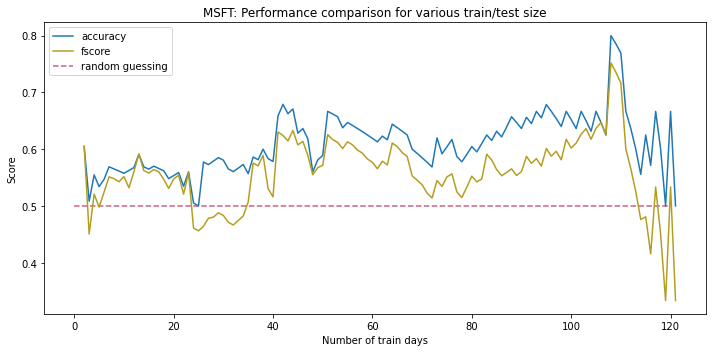

In [331]:
ax = df_holdout.sort_index()[['accuracy','fscore']].plot(figsize=(10,5),
                                                         color = ['#1f77b4','#b49e1f'],
                                                         title='MSFT: Performance comparison for various train/test size')
ax.hlines(y = 0.5, xmin=0, xmax=df_holdout.shape[0], alpha = 0.7, color='#b41f4c', linestyle='dashed', label = 'random guessing')
ax.set_xlabel('Number of train days')
ax.set_ylabel('Score')
ax.legend()
plt.tight_layout()

plt.show()

In [34]:
df_holdout[['accuracy','fscore']].mean(axis=0)

accuracy    0.609168
fscore      0.558120
dtype: float64

### trying time-cross validation

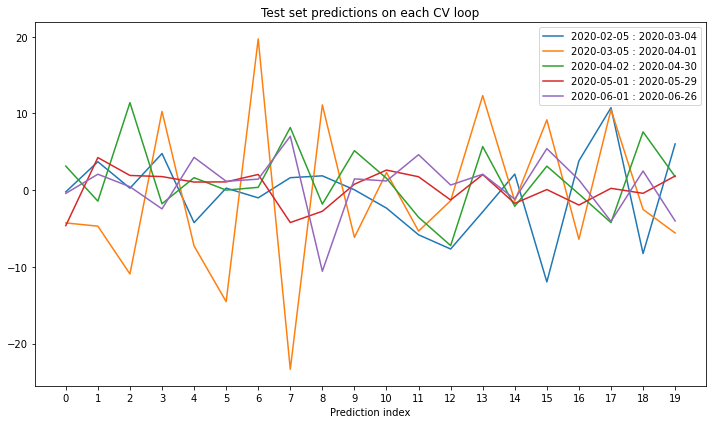

In [35]:
company = 'MSFT'
X_features = ['Adj close']
X = stock_prices.loc[stock_prices.ticker == company, X_features].diff().dropna()
y = stock_prices.loc[stock_prices.ticker == company,'class'].iloc[1:]

n_splits = 5
test_size = X.shape[0]//(n_splits + 1)
cv = TimeSeriesSplit(n_splits=n_splits)
fig, axs = plt.subplots(1, 1, figsize=(10,6))# Plot the indices chosen for validation on each loop

for tr, tt in cv.split(X, y):
    
    min_date = str(X.iloc[tt].index.min())[:10]
    max_date = str(X.iloc[tt].index.max())[:10]

    # Plot the model predictions on each iteration
    axs.plot(range(len(tt)) , X.iloc[tt], label=f"{min_date} : {max_date}" )
    axs.set(title='Test set predictions on each CV loop',            
               xlabel='Prediction index')
    axs.set_xticks(np.arange(test_size))
    
plt.legend()
plt.tight_layout()
plt.show()

In [517]:
company = 'MSFT'
X_features = ['Adj close']
X = stock_prices.loc[stock_prices.ticker == company, X_features].diff().dropna()
y = stock_prices.loc[stock_prices.ticker == company,'class'].iloc[1:]

n_splits = 5
test_size = X.shape[0]//(n_splits + 1)
cv = TimeSeriesSplit(n_splits=n_splits)
df = pd.DataFrame(columns=['accuracy','precision','recall','fscore','auc'])

for idx, (tr, tt) in enumerate(cv.split(X, y)):
    
    X_train = X.iloc[tr]
    X_test = X.iloc[tt]
    y_train = y.iloc[tr]
    y_test =  y.iloc[tt]

# Standardization wrosen the results
#     scaler = StandardScaler()
    
#     X_train = scaler.fit_transform(X_train)
#     X_test = scaler.transform(X_test)
    
    svc = SVC(kernel='linear',C=0.033, gamma=8.03,random_state=42)
    
    # for test sample with only one class, metrics cannot be computed and the function returns NaN
    # to avoid errors we simply disregard such results
    try:
        accuracy, precision, recall, fscore, auc_score = run_ho_model(svc, X_train, X_test, y_train, y_test )
        df.loc[idx] = [accuracy, precision, recall, fscore, auc_score]
    
    except:
        pass    

In [235]:
# results with no diff
df.mean()

accuracy     0.480000
precision    0.346442
recall       0.480000
fscore       0.362995
auc          0.386060
dtype: float64

In [497]:
# results with diff
df.mean()

accuracy     0.600000
precision    0.596278
recall       0.600000
fscore       0.569773
auc          0.686198
dtype: float64

In [518]:
# results with diff + standardization
df.mean()

accuracy     0.600000
precision    0.455279
recall       0.600000
fscore       0.501684
auc          0.713053
dtype: float64

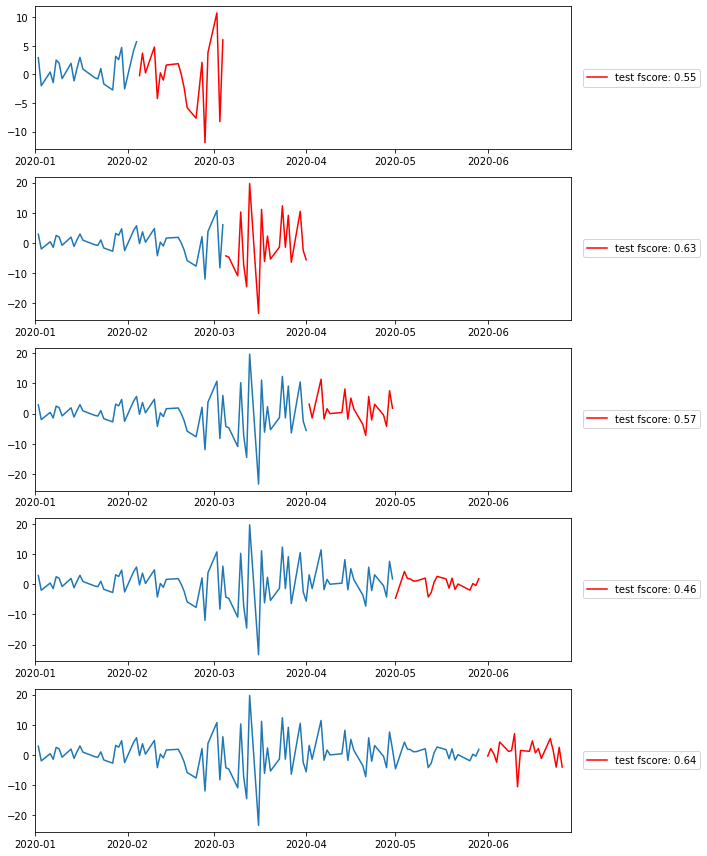

In [36]:
company = 'MSFT'
X_features = ['Adj close']
X = stock_prices.loc[stock_prices.ticker == company, X_features].diff().dropna()
y = stock_prices.loc[stock_prices.ticker == company,'class'].iloc[1:]

n_splits= 5
tscv = TimeSeriesSplit(n_splits=n_splits)
fig, axes = plt.subplots(n_splits,1, figsize=(10,12))
idx = 0
for tr, tt in tscv.split(X):
    X_train = X.iloc[tr]
    X_test = X.iloc[tt]
    y_train = y.iloc[tr]
    y_test =  y.iloc[tt]
    
    #scaler = StandardScaler()
    
    #X_train = scaler.fit_transform(X_train)
    #X_test = scaler.transform(X_test)
    
    svc = SVC(random_state=42)
    accuracy, precision, recall, fscore, auc_score = run_ho_model(svc, X_train, X_test, y_train, y_test )

    axes[idx].plot(y_train.index, X_train)
    axes[idx].plot(y_test.index, X_test, c='r' , label=f'test fscore: {np.round(fscore,2)}')
    axes[idx].set_xlim(pd.Timestamp('2020-01-01'),pd.Timestamp('2020-06-29'))
    axes[idx].legend(bbox_to_anchor=(1.25, 0.6))
    idx += 1

plt.tight_layout()
plt.show()

### Model performance over time - time-series split

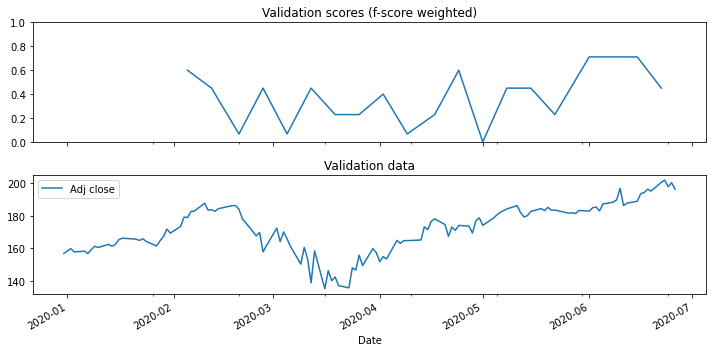

In [47]:
company = 'MSFT'
X_features = ['Adj close']
X = stock_prices.loc[stock_prices.ticker == company, X_features]#.diff().dropna()
y = stock_prices.loc[stock_prices.ticker == company,'class']#.iloc[1:]

n_splits= 20
tscv = TimeSeriesSplit(n_splits=n_splits)

first_indices = [X.index[tt[0]] for tr, tt in tscv.split(X,y)]

svc = SVC(random_state=42)

cv_scores = cross_val_score(svc, X, y, cv=tscv, scoring='f1_weighted')
cv_scores = pd.Series(cv_scores, index=first_indices)


fig, axes = plt.subplots(2,1,figsize=(10,5), sharex=True)

# calcualate rolling mean of scores over time
cv_scores_rolling = cv_scores.rolling(3,min_periods=1).mean()
cv_scores.plot(ax=axes[0])
axes[0].set(title='Validation scores (f-score weighted)', ylim=[0,1])

# plot the raw data

X.plot(ax=axes[1])
axes[1].set(title='Validation data')

plt.tight_layout()

plt.show()

### trying slliding window validation

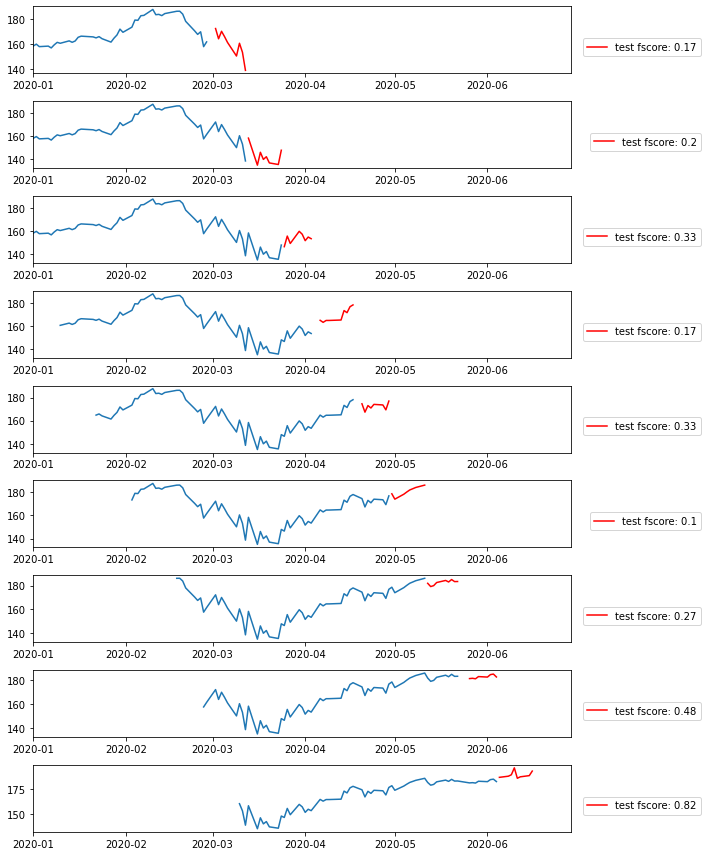

In [214]:
df = stock_prices[stock_prices.ticker == 'MSFT']
df.loc[:,'record_date'] = df.index

X = df[['record_date','Adj close']]
y = df['class']

tscv = TimeBasedCV(train_period=87,
                   test_period=12,
                   freq='days')

tscv_split = tscv.split(X, validation_split_date=datetime.date(2020,3,1))



fig, axes = plt.subplots(len(tscv_split),1, figsize=(10,12))
idx = 0
for tr, tt in tscv_split:
    
    X_train   = X.loc[tr].drop('record_date', axis=1)
    y_train = y.loc[tr]

    X_test    = X.loc[tt].drop('record_date', axis=1)
    y_test  = y.loc[tt]
    
    svc = SVC(random_state=42)
    accuracy, precision, recall, fscore, auc_score = run_ho_model(svc, X_train, X_test, y_train, y_test )
    
    axes[idx].plot(X_train)
    axes[idx].plot(X_test, c='r' , label=f'test fscore: {np.round(fscore,2)}')
    axes[idx].set_xlim(pd.Timestamp('2020-01-01'),pd.Timestamp('2020-06-29'))
    axes[idx].legend(bbox_to_anchor=(1.25, 0.6))
    idx += 1


plt.tight_layout()
plt.show()

In [227]:
performance_results = pd.DataFrame(columns=['accuracy','precision','recall','fscore','auc'])
    
df = stock_prices[stock_prices.ticker == 'MSFT']
df.loc[:,'record_date'] = df.index

X = df[['record_date','Adj close']]
y = df['class']

tscv = TimeBasedCV(train_period=30,
                   test_period=10,
                   freq='days')

for idx, (tr, tt) in enumerate(tscv.split(X, validation_split_date=datetime.date(2020,3,1))):
    
    X_train   = X.loc[tr].drop('record_date', axis=1)#.diff().dropna()
    y_train   = y.loc[tr]#.iloc[1:]

    X_test    = X.loc[tt].drop('record_date', axis=1)#.diff().dropna()
    y_test    = y.loc[tt]#.iloc[1:]
    

    svc = SVC(random_state=42)
    try:
        accuracy, precision, recall, fscore, auc_score = run_ho_model(svc, X_train, X_test, y_train, y_test )
        performance_results.loc[idx] = [accuracy, precision, recall, fscore, auc_score]
    except:
        pass

In [225]:
performance_results.mean()

accuracy     0.566190
precision    0.494751
recall       0.566190
fscore       0.482302
auc          0.641111
dtype: float64

###  Model performance over time - sliding window split

In [203]:
def get_number_index(X, X_train, X_test):
    train_min = X.index.get_loc(X_train.index.min())
    train_max =X.index.get_loc(X_train.index.max())
    
    test_min = X.index.get_loc(X_test.index.min())
    test_max = X.index.get_loc(X_test.index.max())
    
    return (np.arange(train_min,train_max+1), np.arange(test_min, test_max+1))

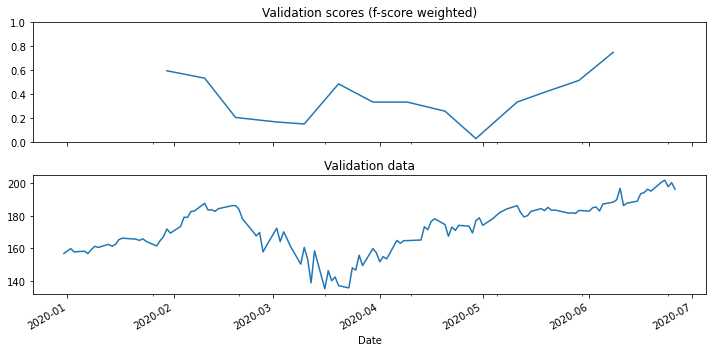

In [167]:
# TimeBasedCV requires X data to have record_date attribute
# prepares train-test spllit for cross_val_score / gridsearch

df = stock_prices[stock_prices.ticker == 'MSFT']
df.loc[:,'record_date'] = df.index

X = df[['record_date','Adj close']]
y = df['class']

tscv = TimeBasedCV(train_period=30,
                   test_period=10,
                   freq='days')

index_output = tscv.split(X)

# index output is a list of lists cotnaininf datetime variables, for corss_val_score we need
# a list of arrays with numerical indices e.g. [(array([1,2,3]), array(4,5,6)), (array([7,8,9]), array(10,11,12)) ]

out_list = []
for tup in index_output:
    number_index = get_number_index(X, X.loc[tup[0]], X.loc[tup[1]])
    out_list.append(number_index)

# get a start date of each test set for visualisation 
first_indices = [X.loc[tt[0]].values[0] for tr, tt in tscv.split(X)]


# cross_val_score needs data without record_date
company = 'MSFT'
X_features = ['Adj close']
X = stock_prices.loc[stock_prices.ticker == company, X_features]#.diff().dropna()
y = stock_prices.loc[stock_prices.ticker == company,'class']#.iloc[1:]

# initate model
svc = SVC(random_state=42)

# get corss val scores
cv_scores = cross_val_score(svc, X, y, cv=out_list, scoring='f1_weighted')

# save into series
cv_scores = pd.Series(cv_scores, index=first_indices)

# plot the results
fig, axes = plt.subplots(2,1,figsize=(10,5), sharex=True)

# calcualate rolling mean of scores over time
cv_scores_rolling = cv_scores.rolling(3,min_periods=1).mean()
cv_scores.plot(ax=axes[0])
axes[0].set(title='Validation scores (f-score weighted)', ylim=[0,1])

# plot the raw data

X['Adj close'].plot(ax=axes[1])
axes[1].set(title='Validation data')

plt.tight_layout()

plt.show()

### combined results

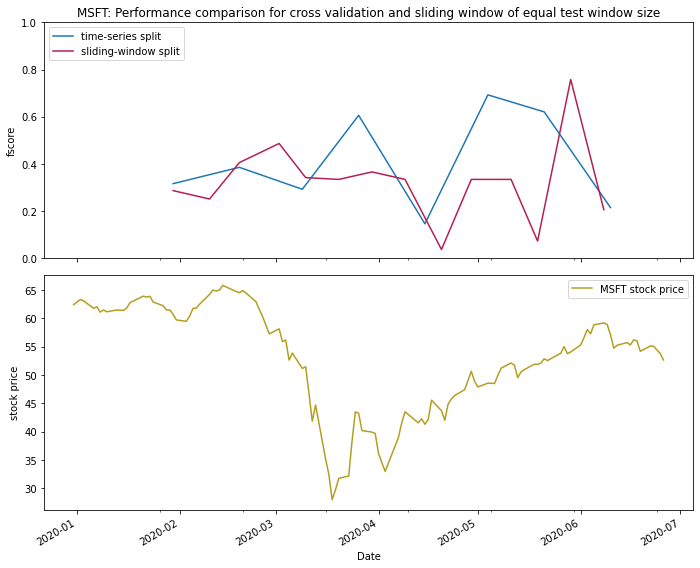

In [596]:
## time-series split ################################################################
company = 'QSR'
X_features = ['Adj close']
X = stock_prices.loc[stock_prices.ticker == company, X_features]#.diff().dropna()
y = stock_prices.loc[stock_prices.ticker == company,'class']#.iloc[1:]

n_splits= 8
tscv = TimeSeriesSplit(n_splits=n_splits)

first_indices = [X.index[tt[0]] for tr, tt in tscv.split(X,y)]

svc = SVC(random_state=42)

cv_scores = cross_val_score(svc, X, y, cv=tscv, scoring='f1_weighted')
cv_scores = pd.Series(cv_scores, index=first_indices)


# sliding window  ###################################################################

# TimeBasedCV requires X data to have record_date attribute
# prepares train-test spllit for cross_val_score / gridsearch

df = stock_prices[stock_prices.ticker == company]
df.loc[:,'record_date'] = df.index

X_sw = df[['record_date','Adj close']]
y_sw = df['class']

tscv_sw = TimeBasedCV(train_period=30,
                   test_period=10,
                   freq='days')

index_output_sw = tscv_sw.split(X_sw)

# index output is a list of lists cotnaininf datetime variables, for corss_val_score we need
# a list of arrays with numerical indices e.g. [(array([1,2,3]), array(4,5,6)), (array([7,8,9]), array(10,11,12)) ]

out_list = []
for tup in index_output_sw:
    number_index = get_number_index(X_sw, X_sw.loc[tup[0]], X_sw.loc[tup[1]])
    out_list.append(number_index)

# get a start date of each test set for visualisation 
first_indices_sw = [X_sw.loc[tt[0]].values[0] for tr, tt in tscv_sw.split(X_sw)]


# cross_val_score needs data without record_date

X_features = ['Adj close']
X_sw = stock_prices.loc[stock_prices.ticker == company, X_features]#.diff().dropna()
y_sw = stock_prices.loc[stock_prices.ticker == company,'class']#.iloc[1:]

# initate model
svc = SVC(random_state=42)

# get corss val scores
cv_scores_sw = cross_val_score(svc, X_sw, y_sw, cv=out_list, scoring='f1_weighted')

# save into series
cv_scores_sw = pd.Series(cv_scores_sw, index=first_indices_sw)


## Plot  ###################################################################

# plot the results
fig, axes = plt.subplots(2,1,figsize=(10,8), sharex=True)

roll_window = 3

# calcualate rolling mean of scores over time 
#cv_scores_rolling = cv_scores.rolling(roll_window, min_periods=1).mean()
cv_scores.plot(ax=axes[0], c = '#1f77b4' ,label = 'time-series split')

# calcualate rolling mean of scores over time - sliding window
#cv_scores_rolling_sw = cv_scores_sw.rolling(roll_window, min_periods=1).mean()
cv_scores_sw.plot(ax=axes[0], c= '#b41f4c' ,label = 'sliding-window split')
axes[0].set(title='MSFT: Performance comparison for cross validation and sliding window of equal test window size', ylim=[0,1], ylabel='fscore')

axes[0].legend(loc='upper left')
# plot the raw data

X_sw['Adj close'].plot(ax=axes[1], c = '#b49e1f',label = 'MSFT stock price')
axes[1].set(ylabel='stock price')
axes[1].legend()


plt.tight_layout()

plt.show()

In [598]:
cv_scores_sw.mean()

0.32391259534116673

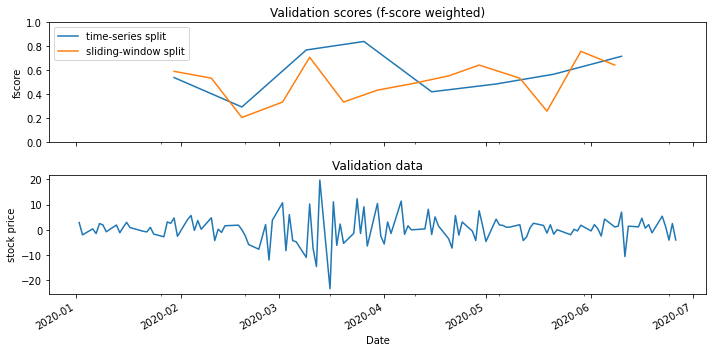

In [588]:
## time-series split ################################################################
company = 'MSFT'
X_features = ['Adj close']
X = stock_prices.loc[stock_prices.ticker == company, X_features].diff().dropna()
y = stock_prices.loc[stock_prices.ticker == company,'class'].iloc[1:]

n_splits= 8
tscv = TimeSeriesSplit(n_splits=n_splits)

first_indices = [X.index[tt[0]] for tr, tt in tscv.split(X,y)]

svc = SVC(random_state=42)

cv_scores = cross_val_score(svc, X, y, cv=tscv, scoring='f1_weighted')
cv_scores = pd.Series(cv_scores, index=first_indices)


# sliding window  ###################################################################

# TimeBasedCV requires X data to have record_date attribute
# prepares train-test spllit for cross_val_score / gridsearch

df = stock_prices[stock_prices.ticker == 'MSFT']
df.loc[:,'record_date'] = df.index

X_sw = df[['record_date','Adj close']]
y_sw = df['class']

tscv_sw = TimeBasedCV(train_period=30,
                   test_period=10,
                   freq='days')

index_output_sw = tscv_sw.split(X_sw)

# index output is a list of lists cotnaininf datetime variables, for corss_val_score we need
# a list of arrays with numerical indices e.g. [(array([1,2,3]), array(4,5,6)), (array([7,8,9]), array(10,11,12)) ]

out_list = []
for tup in index_output_sw:
    number_index = get_number_index(X_sw, X_sw['Adj close'].loc[tup[0]], X_sw['Adj close'].loc[tup[1]])
    out_list.append(number_index)

# get a start date of each test set for visualisation 
first_indices_sw = [X_sw.loc[tt[0]].values[0] for tr, tt in tscv_sw.split(X_sw)]

# cross_val_score needs data without record_date
company = 'MSFT'
X_features = ['Adj close']
X_sw = stock_prices.loc[stock_prices.ticker == company, X_features].diff().dropna()
y_sw = stock_prices.loc[stock_prices.ticker == company,'class'].iloc[1:]

# initate model
svc = SVC(random_state=42)

# get corss val scores
cv_scores_sw = cross_val_score(svc, X_sw, y_sw, cv=out_list, scoring='f1_weighted')

# save into series
cv_scores_sw = pd.Series(cv_scores_sw, index=first_indices_sw)


## Plot  ###################################################################

# plot the results
fig, axes = plt.subplots(2,1,figsize=(10,5), sharex=True)

roll_window = 3

# calcualate rolling mean of scores over time 
#cv_scores_rolling = cv_scores.rolling(roll_window, min_periods=1).mean()
cv_scores.plot(ax=axes[0], label = 'time-series split')

# calcualate rolling mean of scores over time - sliding window
#cv_scores_rolling_sw = cv_scores_sw.rolling(roll_window, min_periods=1).mean()
cv_scores_sw.plot(ax=axes[0], label = 'sliding-window split')
axes[0].set(title='Validation scores (f-score weighted)', ylim=[0,1], ylabel='fscore')

axes[0].legend()
# plot the raw data

X_sw['Adj close'].plot(ax=axes[1])
axes[1].set(title='Validation data', ylabel='stock price')



plt.tight_layout()

plt.show()

In [347]:
# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
# https://www.quora.com/What-does-it-mean-to-have-high-AUC-but-low-F1-score#:~:text=So%2C%20if%20you're%20having,other%20thresholds%20(bad%20classifier).
performance_results.sort_values('precision', ascending=False)[:20] # how to interpret this?

,tr,tt,accuracy,precision,recall,fscore,auc
168,22.0,14.0,0.551515,0.519856,0.551515,0.486271,0.563167
1050,90.0,12.0,0.636905,0.514440,0.636905,0.538605,0.443793
24,11.0,13.0,0.558102,0.511980,0.558102,0.466486,0.473733
70,15.0,7.0,0.565217,0.498913,0.565217,0.484161,0.518116
161,22.0,7.0,0.559091,0.495076,0.559091,0.478608,0.590909
1051,90.0,13.0,0.576389,0.492353,0.576389,0.474995,0.366905
241,28.0,9.0,0.506696,0.488022,0.506696,0.426098,0.605556
129,19.0,14.0,0.536364,0.483998,0.536364,0.427518,0.614758
142,20.0,14.0,0.536364,0.483998,0.536364,0.427518,0.614758
116,18.0,14.0,0.536364,0.483998,0.536364,0.427518,0.614758


In [344]:
performance_results[['accuracy','precision','recall','fscore','auc']].agg(['min','max','mean','std'])

,accuracy,precision,recall,fscore,auc
min,0.385582,0.201337,0.385582,0.259375,0.291582
max,0.636905,0.519856,0.636905,0.538605,0.923077
mean,0.505112,0.341546,0.505112,0.379308,0.578525
std,0.036158,0.057644,0.036158,0.040706,0.097348


# SVC

In [459]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [511]:
company = 'MSFT'
X_features = ['Adj close']
X = stock_prices.loc[stock_prices.ticker == company, X_features].diff().dropna()
y = stock_prices.loc[stock_prices.ticker == company,'class'].iloc[1:]

params = {'clf__kernel' : ['rbf','linear','sigmoid'],
               'clf__C' : stats.uniform(0.02, 0.02),
           'clf__gamma' : stats.uniform(5, 10)
          }

scoring = {'accuracy' : 'balanced_accuracy',
            'precision_weighted' : 'precision_weighted',
            'recall_weighted' : 'recall_weighted',
            'f1_weighted': 'f1_weighted',
            'roc_auc' : make_scorer(roc_auc_score) }

pipeline = Pipeline([
    ('stand', StandardScaler()),
    ('clf', SVC(random_state=42)),
])

n_splits= 5
tscv = TimeSeriesSplit(n_splits=n_splits)


model = RandomizedSearchCV(
    estimator = pipeline,
    param_distributions = params,
    n_iter = 100,
    n_jobs = -1,
    cv = tscv,
    verbose=5,
    pre_dispatch='2*n_jobs',
    random_state = 7,
    return_train_score = True,
    scoring = scoring,
    refit = 'f1_weighted')

model.fit(X,y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    3.9s finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
                   estimator=Pipeline(steps=[('clf', SVC(random_state=42))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'clf__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020C262FC7C8>,
                                        'clf__gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020C25F49248>,
                                        'clf__kernel': ['rbf', 'linear',
                                                        'sigmoid']},
                   random_state=7, refit='f1_weighted', return_train_score=True,
                   scoring={'accuracy': 'balanced_accuracy',
                            'f1_weighted': 'f1_weighted',
                            'precision_weighted': 'precision_weighted',
                            'recall_weighted': 'recall_weighted',
                            'roc_auc': make_scorer(roc_auc_score)},
    

In [512]:
rgs_results = pd.DataFrame(model.cv_results_)

In [513]:
rgs_results.loc[:,(rgs_results.columns.isin(['params'])) | (rgs_results.columns.str.contains('mean_test'))].sort_values(['mean_test_f1_weighted'], ascending=False)

,params,mean_test_accuracy,mean_test_precision_weighted,mean_test_recall_weighted,mean_test_f1_weighted,mean_test_roc_auc
87,"{'clf__C': 0.031301037345420765, 'clf__gamma': 8.038220970385176, 'clf__kernel': 'linear'}",0.605322,0.671775,0.66,0.627859,0.605322
85,"{'clf__C': 0.03369808074120228, 'clf__gamma': 13.168939943424482, 'clf__kernel': 'linear'}",0.605322,0.671775,0.66,0.627859,0.605322
27,"{'clf__C': 0.03364903902166136, 'clf__gamma': 10.019234890075488, 'clf__kernel': 'linear'}",0.605322,0.671775,0.66,0.627859,0.605322
38,"{'clf__C': 0.034563225662942676, 'clf__gamma': 13.212276083065595, 'clf__kernel': 'linear'}",0.605322,0.671775,0.66,0.627859,0.605322
39,"{'clf__C': 0.030268020034900797, 'clf__gamma': 6.784257547576489, 'clf__kernel': 'linear'}",0.605322,0.671775,0.66,0.627859,0.605322
14,"{'clf__C': 0.03145250665287908, 'clf__gamma': 7.760490483306951, 'clf__kernel': 'linear'}",0.605322,0.671775,0.66,0.627859,0.605322
28,"{'clf__C': 0.035716333860978694, 'clf__gamma': 14.513361410416794, 'clf__kernel': 'linear'}",0.596232,0.646848,0.65,0.619450,0.596232
31,"{'clf__C': 0.03556427203087793, 'clf__gamma': 13.872889518527348, 'clf__kernel': 'linear'}",0.596232,0.646848,0.65,0.619450,0.596232
46,"{'clf__C': 0.03593902714887129, 'clf__gamma': 14.751396811571157, 'clf__kernel': 'linear'}",0.596232,0.646848,0.65,0.619450,0.596232
1,"{'clf__C': 0.026160255303754786, 'clf__gamma': 7.638708390378986, 'clf__kernel': 'linear'}",0.594211,0.667821,0.65,0.612606,0.594211


# Decision Tree

In [ ]:
    # Create lists of parameter for Decision Tree Classifier
    criterion = ['gini', 'entropy']
    max_depth = [4,6,8,12]

    # Create a dictionary of all the parameter options 
    # Note has you can access the parameters of steps of a pipeline by using '__’
    parameters = dict(pca__n_components=n_components,
                      decisiontree__criterion=criterion,
                      decisiontree__max_depth=max_depth)

## Feature Selection

In [ ]:
def find_best_params(rgs, main_scoring_metric):
    # max score metric
    scoring_attr = "mean_test_" + main_scoring_metric
    
    rgs = rgs.loc[(rgs[scoring_attr] == rgs[scoring_attr].max()),:]
    # min fitting time
    rgs = rgs.loc[(rgs['mean_fit_time'] == rgs['mean_fit_time'].min()),:]
    
    return rgs.params.values[0] #dictionary of parameters

In [ ]:
def tune_parameters(model, params, company, X_features, X, y, main_scoring_metric = 'f1_weighted'):
    

    scoring = {'accuracy' : 'balanced_accuracy',
                'precision_weighted' : 'precision_weighted',
                'recall_weighted' : 'recall_weighted',
                'f1_weighted': 'f1_weighted',
                'roc_auc' : make_scorer(roc_auc_score) }


    transformer = FeatureUnion(
        transformer_list=[
            ('imputer',  KNNImputer(n_neighbors=4, weights="uniform")),
            ('indicators', MissingIndicator())])  # flag of imeded values X[np.where(results[:,2] == 1 ,True, False)]


    pipeline = Pipeline([
                     ('transformer', transformer),
                     ('clf', model)
                    ])

    n_splits= 5
    tscv = TimeSeriesSplit(n_splits=n_splits)


    model = RandomizedSearchCV(
        estimator = pipeline,
        param_distributions = params,
        n_iter = 200,
        n_jobs = -1,
        cv = tscv,
        verbose=5,
        pre_dispatch='2*n_jobs',
        random_state = 7,
        return_train_score = True,
        scoring = scoring,
        refit = main_scoring_metric)

    model.fit(X,y)

    return pd.DataFrame(model.cv_results_)

In [ ]:
def feature_selection(model, X, y, main_scoring_metric, n_splits = 5):
    
    # Forwards stepwise feature selection
    tot_num_features = np.shape(X)[-1]
    all_features = range(tot_num_features)
    current_features = []
    remaining_features = list(all_features)

    best_score = 0
    best_features = None
      
    # While we have remaining features...
    while len(current_features) != tot_num_features:
        # Get remaining features 
        candidate_features = [ f for f in all_features if f not in current_features ]
        #print("cand features: ",candidate_features)
       
        best_score_this_round = 0
        best_feature_this_round = None
        
        for f in candidate_features:
            test_features = current_features + [f]
            
            
            tscv = TimeSeriesSplit(n_splits=n_splits)
            cv_scores = cross_val_score(model, X.iloc[:,test_features], y,
                                        cv=tscv,
                                        scoring=main_scoring_metric,
                                        )
            
            score = cv_scores.mean()

            # Remember, higher score is better
            if score > best_score_this_round:
                best_score_this_round = score
                best_feature_this_round = f

            if score > best_score:
                best_score = score
                best_features = test_features
                
        # Set current features to best features from round
        current_features = current_features + [best_feature_this_round]
        #print("cur_features: ", current_features)
        
        #print("Round {}, selected feature {} with score {:.3f}".format(len(current_features), X.columns[best_feature_this_round] , best_score_this_round ))

    #print("Best features were {} ({:d} total) with score {:.3f}".format(X.columns[best_features], len(best_features), best_score))
    return best_score, best_features

In [ ]:
def extract_clf_params(params):
    short_keys = {}
    for key, value in params.items():
        short_keys[key[key.find('clf__')+5:]] = value
    return short_keys

In [ ]:
def find_best_model(model, params, company, X_features, X, y, main_scoring_metric = 'f1_weighted'):
    
    df = tune_parameters(model, params, company, X_features, X, y, main_scoring_metric)
    print("tunning done!")
    
    new_params = find_best_params(df, main_scoring_metric)
    new_params = extract_clf_params(new_params)
    print("Initial parameters:", new_params)
    
    
    model = SVC(**new_params, random_state=42)
    
    best_score, best_features = feature_selection(model, X, y, main_scoring_metric, n_splits = 5 )
    print("Best score found", best_score)
    print("Best features", np.array(X_features)[best_features])
    
    df = tune_parameters(model, params, company, best_features, X, y, main_scoring_metric )
    
    return df

In [ ]:
company = 'MSFT'

X_features =  ['Open', 'High', 'Low', 'Close','Adj close', 'MA_3D_mean', 'MA_5D_mean', 'MA_7D_mean', 'MA_3D_std',
              'MA_5D_std', 'MA_7D_std', 'MA_3D_min', 'MA_5D_min', 'MA_7D_min',
              'MA_3D_max', 'MA_5D_max', 'MA_7D_max', 'lag_1', 'lag_2', 'lag_3', 'lag_4',
              'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_15', 'lag_20',
              'lag_25', 'lag_30', 'spacy_lex']

X = df.loc[df.ticker == company,X_features]
X.loc[:,'Adj close'] = df.loc[df.ticker == company, 'Adj close'].diff()
X = X.dropna()

y = df.loc[df.ticker == company,'class']
y = df.loc[df.ticker == company,'class'].iloc[y.shape[0]-X.shape[0]:]

params = {'clf__kernel' : ['rbf','linear','sigmoid'],
               'clf__C' : stats.uniform(0, 2),
           'clf__gamma' : stats.uniform(1, 9)
          }

svc = SVC(random_state=42)

results = find_best_model(svc, params, company, X_features, X, y, main_scoring_metric = 'f1_weighted')

In [ ]:
results.loc[:,(results.columns.isin(['params'])) | (results.columns.str.contains('mean_test'))].sort_values(['mean_test_f1_weighted'], ascending=False)

### Forward step feature selection

In [ ]:
# Forward step feature selection 
def fsfs(X,y, continuous_features, score_function=aic):  

    # Forwards stepwise feature selection
    tot_num_features = np.shape(X)[-1]
    all_features = range(tot_num_features)
    current_features = []
    remaining_features = list(all_features)

    best_score = 1e9
    best_features = None
      
    # While we have remaining features...
    while len(current_features) != tot_num_features:
        # Get remaining features 
        candidate_features = [ f for f in all_features if f not in current_features ]
       
        best_score_this_round = 1e9
        best_feature_this_round = None
        
        for f in candidate_features:
            test_features = current_features + [f]
            
            
            learned_coefficients = fit_linear( X, y, test_features )

            score = score_function(X,learned_coefficients,test_features)

            #print(f"{len(candidate_features)}")

            # Remember, lower score is better
            if score < best_score_this_round:
                best_score_this_round = score
                best_feature_this_round = f

            if score < best_score:
                best_score = score
                best_features = test_features
                
        # Set current features to best features from round
        current_features = current_features + [best_feature_this_round]
        
        print("Round {}, selected feature {:d} with score {:.3f}"\
              .format(len(current_features), best_feature_this_round, best_score_this_round ))

    print("Best features were {} ({:d} total) with score {:.3f}".format(best_features, len(best_features), best_score))

In [ ]:
y = data[:, 0] # target is first value
X = data[:, 1:] # training data is the rest

# Normalize the data to zero mean and unit std
X = (X - np.mean(X, axis=0, keepdims=True)) / np.std(X, axis=0, keepdims=True)
y = (y - np.mean(y)) / np.std(y)

# Forwards stepwise feature selection
tot_num_features = np.shape(X)[-1]
all_features = range(tot_num_features)
current_features = []
remaining_features = list(all_features)

best_score = 1e9
best_features = None

### Plot ROC

In [282]:
fpr, tpr, threshold = roc_curve(y_test, ydf)
auc_score = roc_auc_score(y_test, ydf) 

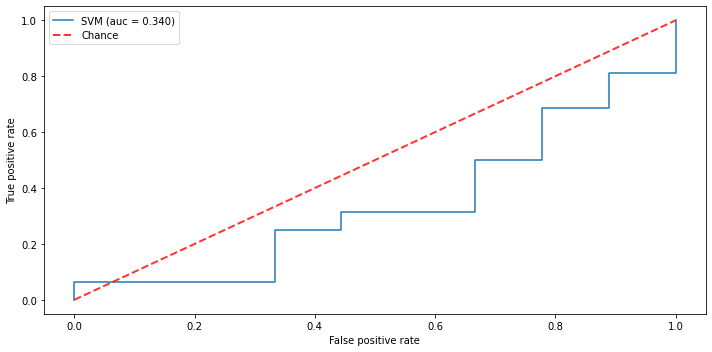

In [283]:
fig, axes = plt.subplots(1,1, figsize=(10,5))
axes.plot(fpr, tpr, label = "SVM (auc = %0.3f)" % auc_score)
axes.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.tight_layout()
plt.show()

### Choosing features with greatest impact for linear kernel SVC

In [43]:
# https://stackoverflow.com/questions/41592661/determining-the-most-contributing-features-for-svm-classifier-in-sklearn
def f_importances(coef, names):
    imp = coef[0]
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

In [36]:
svm = SVC(kernel='linear')
svm.fit(X[7:], y[7:])

SVC(kernel='linear')

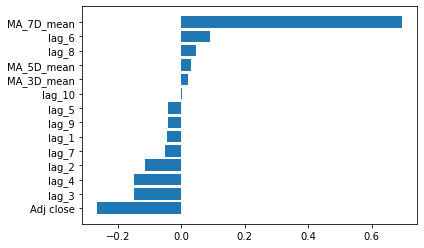

In [44]:
f_importances(svm.coef_, np.array(X_features).ravel())

### Another proof of non-stationerity

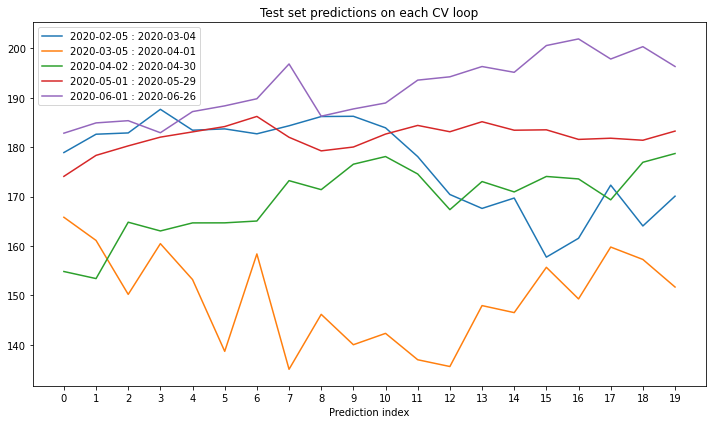

In [93]:
# We see that the time-series is not statioanry throughout the time, as the target varies quite a bit 
# as it move in time. This might be an issue.

n_splits = 5
test_size = X.shape[0]//(n_splits + 1)
cv = TimeSeriesSplit(n_splits=n_splits)
fig, axs = plt.subplots(1, 1, figsize=(10,6))# Plot the indices chosen for validation on each loop

for tr, tt in cv.split(X, y):
    
    min_date = str(X.iloc[tt].index.min())[:10]
    max_date = str(X.iloc[tt].index.max())[:10]

    # Plot the model predictions on each iteration
    axs.plot(range(len(tt)) , X.iloc[tt], label=f"{min_date} : {max_date}" )
    axs.set(title='Test set predictions on each CV loop',            
               xlabel='Prediction index')
    axs.set_xticks(np.arange(test_size))
    
plt.legend()
plt.tight_layout()
plt.show()

### Bootstrapping the mean

In [115]:
from sklearn.utils import resample

n_coefficients = X.shape[1]

n_splits= 5
tscv = TimeSeriesSplit(n_splits=n_splits)

percentiles_results = []

for tr, tt in tscv.split(X):

    # cv_coefficients has shape (n_cv_folds, n_coefficients)
    n_boots = 100
    bootstrap_means = np.zeros((n_boots, n_coefficients))

    for ii in range(n_boots):
        # Generate random indices for our data with replacement, 
        # then take the sample mean    
        random_sample = resample(X.iloc[tt].index)
        bootstrap_means[ii] = X.iloc[tt].loc[random_sample].mean(axis=0)
        # Compute the percentiles of choice for the bootstrapped means

    percentiles = np.percentile(bootstrap_means, (2.5, 97.5), axis=0)
    percentiles_results.append(percentiles)
    
percentiles_results = np.array(percentiles_results).reshape(len(percentiles_results),len(percentiles_results[0]))

In [116]:
percentiles_results[:,0]

array([172.9822125, 145.6367125, 166.7005625, 180.9389   , 189.5279625])

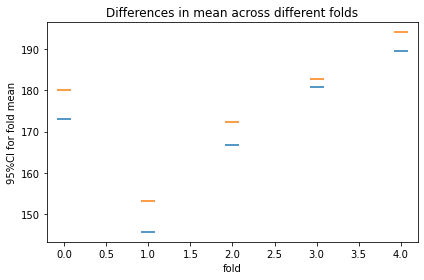

In [119]:
# the series is not stationary
fig, ax = plt.subplots()
ax.scatter(range(5), percentiles_results[:,0], marker='_', s=200)
ax.scatter(range(5), percentiles_results[:,1], marker='_', s=200)
ax.set(xlabel='fold', ylabel='95%CI for fold mean', title='Differences in mean across different folds')
plt.tight_layout()
plt.show()

# Code for later

In [ ]:
#### Example- RandomizedSearchCV ####
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMRegressor
from random import randint, uniform

tscv = TimeBasedCV(train_period=10, test_period=3)
index_output = tscv.split(data_for_modeling, validation_split_date=datetime.date(2019,2,1))

lgbm = LGBMRegressor()

lgbmPd = {" max_depth": [-1,2]
         }

model = RandomizedSearchCV(
    estimator = lgbm,
    param_distributions = lgbmPd,
    n_iter = 10,
    n_jobs = -1,
    iid = True,
    cv = index_output,
    verbose=5,
    pre_dispatch='2*n_jobs',
    random_state = None,
    return_train_score = True)

model.fit(X.drop('record_date', axis=1),y)
model.cv_results_
#### End of example ####

In [49]:
# Time based CV for sliding window
import pandas as pd
import datetime
from datetime import datetime as dt
from dateutil.relativedelta import *

class TimeBasedCV(object):
    '''
    Parameters 
    ----------
    train_period: int
        number of time units to include in each train set
        default is 30
    test_period: int
        number of time units to include in each test set
        default is 7
    freq: string
        frequency of input parameters. possible values are: days, months, years, weeks, hours, minutes, seconds
        possible values designed to be used by dateutil.relativedelta class
        deafault is days
    '''
    
    
    def __init__(self, train_period=30, test_period=7, freq='days'):
        self.train_period = train_period
        self.test_period = test_period
        self.freq = freq

        
        
    def split(self, data, validation_split_date=None, date_column='record_date', gap=0):
        '''
        Generate indices to split data into training and test set
        
        Parameters 
        ----------
        data: pandas DataFrame
            your data, contain one column for the record date 
        validation_split_date: datetime.date()
            first date to perform the splitting on.
            if not provided will set to be the minimum date in the data after the first training set
        date_column: string, deafult='record_date'
            date of each record
        gap: int, default=0
            for cases the test set does not come right after the train set,
            *gap* days are left between train and test sets
        
        Returns 
        -------
        train_index ,test_index: 
            list of tuples (train index, test index) similar to sklearn model selection
        '''
        
        # check that date_column exist in the data:
        try:
            data[date_column]
        except:
            raise KeyError(date_column)
                    
        train_indices_list = []
        test_indices_list = []

        if validation_split_date==None:
            validation_split_date = data[date_column].min().date() + eval('relativedelta('+self.freq+'=self.train_period)')
        
        start_train = validation_split_date - eval('relativedelta('+self.freq+'=self.train_period)')
        end_train = start_train + eval('relativedelta('+self.freq+'=self.train_period)')
        start_test = end_train + eval('relativedelta('+self.freq+'=gap)')
        end_test = start_test + eval('relativedelta('+self.freq+'=self.test_period)')

        while end_test < data[date_column].max().date():
            # train indices:
            cur_train_indices = list(data[(data[date_column].dt.date>=start_train) & 
                                     (data[date_column].dt.date<end_train)].index)

            # test indices:
            cur_test_indices = list(data[(data[date_column].dt.date>=start_test) &
                                    (data[date_column].dt.date<end_test)].index)
            
            #print("Train period:",start_train,"-" , end_train, ", Test period", start_test, "-", end_test,
            #      "# train records", len(cur_train_indices), ", # test records", len(cur_test_indices))

            train_indices_list.append(cur_train_indices)
            test_indices_list.append(cur_test_indices)

            # update dates:
            start_train = start_train + eval('relativedelta('+self.freq+'=self.test_period)')
            end_train = start_train + eval('relativedelta('+self.freq+'=self.train_period)')
            start_test = end_train + eval('relativedelta('+self.freq+'=gap)')
            end_test = start_test + eval('relativedelta('+self.freq+'=self.test_period)')

        # mimic sklearn output  
        index_output = [(train,test) for train,test in zip(train_indices_list,test_indices_list)]

        self.n_splits = len(index_output)
        
        return index_output
    
    
    def get_n_splits(self):
        """Returns the number of splitting iterations in the cross-validator
        Returns
        -------
        n_splits : int
            Returns the number of splitting iterations in the cross-validator.
        """
        return self.n_splits 